# ELMO Word Embeddings with NLU 

ELMO is not trained on predicting random masked words in contrasts to Bert, which is one of the reasons it yield different Embeddings from BERT.

### Sources :
- https://tfhub.dev/google/elmo/3
- https://arxiv.org/abs/1802.05365

### Paper abstract :

We introduce a new type of deep contextualized word representation that models both (1) complex characteristics of word use (e.g., syntax and semantics), and (2) how these uses vary across linguistic contexts (i.e., to model polysemy). Our word vectors are learned functions of the internal states of a deep bidirectional language model (biLM), which is pre-trained on a large text corpus. We show that these representations can be easily added to existing models and significantly improve the state of the art across six challenging NLP problems, including question answering, textual entailment and sentiment analysis. We also present an analysis showing that exposing the deep internals of the pre-trained network is crucial, allowing downstream models to mix different types of semi-supervision signals.


# 1. Install Java and NLU

In [1]:
import os
! apt-get update -qq > /dev/null   
# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! pip install nlu  > /dev/null    


## 2. Load Model and Embed sample string

In [2]:
import nlu
pipe = nlu.load('elmo')
pipe.predict('He was suprised by the diversity of NLU')

elmo download started this may take some time.
Approximate size to download 334.1 MB
[OK!]


,elmo_embeddings,token
origin_index,,
0,"[-0.027567915618419647, -0.47845372557640076, ...",He
0,"[0.2980785369873047, -0.07382500916719437, -0....",was
0,"[0.28243350982666016, -0.07471296936273575, 0....",suprised
0,"[0.42076045274734497, 0.40719351172447205, -0....",by
0,"[-0.06904851645231247, 0.11261536926031113, 0....",the
0,"[-0.1499328762292862, -0.11983472853899002, 1....",diversity
0,"[0.24783454835414886, -0.248960942029953, 0.02...",of
0,"[0.08950258791446686, -0.03680119290947914, 0....",NLU


# 3. Download Sample dataset

In [3]:
import pandas as pd
# Download the dataset 
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv -P /tmp
# Load dataset to Pandas
df = pd.read_csv('/tmp/train-balanced-sarcasm.csv')
df

--2020-09-15 16:46:19--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.137.126
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.137.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255268960 (243M) [text/csv]
Saving to: ‘/tmp/train-balanced-sarcasm.csv’

train-balanced-sarc 100%[===================>] 243.44M  41.1MB/s    in 6.3s    

2020-09-15 16:46:26 (38.6 MB/s) - ‘/tmp/train-balanced-sarcasm.csv’ saved [255268960/255268960]



,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


# 3. Visualize Embeddings with T-SNE




Lets add Sentiment, Part Of Speech and Emotion to our pipeline because its so easy and so we can hue our T-SNE plots by POS and Sentiment       

In [4]:
pipe.predict('hello word', output_level='token')

,elmo_embeddings,token
origin_index,,
0,"[0.8639583587646484, -0.9602441191673279, 0.47...",hello
0,"[0.8600273132324219, 0.8655539751052856, -0.17...",word


In [5]:
pipe = nlu.load('pos sentiment elmo emotion') # emotion
df['text'] = df['comment']

# We must set output level to token since NLU will infer a different output level for this pipeline composition
predictions = pipe.predict(df[['text','label']].iloc[0:500], output_level='token')
predictions

pos_anc download started this may take some time.
Approximate size to download 4.3 MB
[OK!]
analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]
elmo download started this may take some time.
Approximate size to download 334.1 MB
[OK!]
classifierdl_use_emotion download started this may take some time.
Approximate size to download 20.7 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


,category,category_confidence,label,checked,sentence_embeddings,pos,text,sentiment_confidence,sentiment,elmo_embeddings,token
origin_index,,,,,,,,,,,
0,surprise,0.972704,0,NC,"[[-0.06570463627576828, -0.03522053360939026, ...",NNP,NC and NH.,0.522900,negative,"[0.4888951778411865, 0.02264561504125595, -0.4...",NC
0,surprise,0.972704,0,and,"[[-0.06570463627576828, -0.03522053360939026, ...",CC,NC and NH.,0.522900,negative,"[-0.02477884292602539, -0.20155462622642517, -...",and
0,surprise,0.972704,0,NH,"[[-0.06570463627576828, -0.03522053360939026, ...",NNP,NC and NH.,0.522900,negative,"[0.010294198989868164, -0.7602927684783936, 0....",NH
0,surprise,0.972704,0,.,"[[-0.06570463627576828, -0.03522053360939026, ...",.,NC and NH.,0.522900,negative,"[-0.8871510028839111, -0.20039957761764526, -1...",.
1,fear,0.999838,0,You,"[[-0.0254225991666317, 0.05448468029499054, -0...",PRP,You do know west teams play against west teams...,0.473300,negative,"[0.61176598072052, -0.18037298321723938, -0.66...",You
...,...,...,...,...,...,...,...,...,...,...,...
499,surprise,0.991925,0,for,"[[0.02939368598163128, -0.027575558051466942, ...",IN,Hard drive requirements tend to include extra ...,0.539600,positive,"[-0.2415028065443039, 0.05413343757390976, -0....",for
499,surprise,0.991925,0,the,"[[0.02939368598163128, -0.027575558051466942, ...",DT,Hard drive requirements tend to include extra ...,0.539600,positive,"[-0.06904851645231247, 0.11261536926031113, 0....",the
499,surprise,0.991925,0,file,"[[0.02939368598163128, -0.027575558051466942, ...",NN,Hard drive requirements tend to include extra ...,0.539600,positive,"[0.021550625562667847, 0.38065245747566223, -0...",file


## 3.2 Checkout sentiment distribution

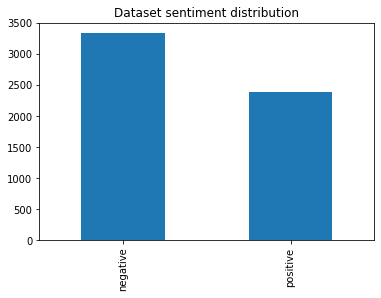

In [6]:
# Some Tokens are None which we must drop first
predictions.dropna(how='any', inplace=True)
# Some sentiment are 'na' which we must drop first
predictions = predictions[predictions.sentiment!= 'na']
predictions.sentiment.value_counts().plot.bar(title='Dataset sentiment distribution')

## 3.3 Checkout sentiment distribution

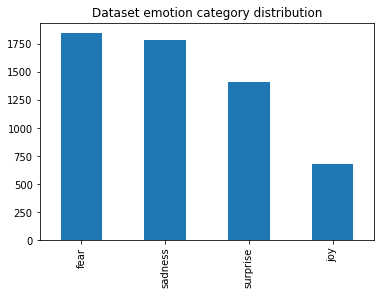

In [7]:
predictions.category.value_counts().plot.bar(title='Dataset emotion category distribution')

# 4.Prepare data for T-SNE algorithm.
We create a Matrix with one row per Embedding vector for T-SNE algorithm

In [8]:
import numpy as np

# We first create a column of type np array
predictions['np_array'] = predictions.elmo_embeddings.apply(lambda x: np.array(x))
# Make a matrix from the vectors in the np_array column via list comprehension
mat = np.matrix([x for x in predictions.np_array])
mat.shape

(5720, 512)

## 4.1 Fit and transform T-SNE algorithm


In [9]:

from sklearn.manifold import TSNE
model = TSNE(n_components=2) #n_components means the lower dimension
low_dim_data = model.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

Lower dim data has shape (5720, 2)


### Set plotting styles

In [10]:
# set some styles for for Plotting
import seaborn as sns
# Style Plots a bit
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1,rc={"lines.linewidth": 2.5})

%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (20, 14)


# 5.1 Plot low dimensional T-SNE ELMO embeddings with hue for POS


Text(0.5, 1.0, 'T-SNE ELMO Embeddings, colored by Part of Speech Tag')

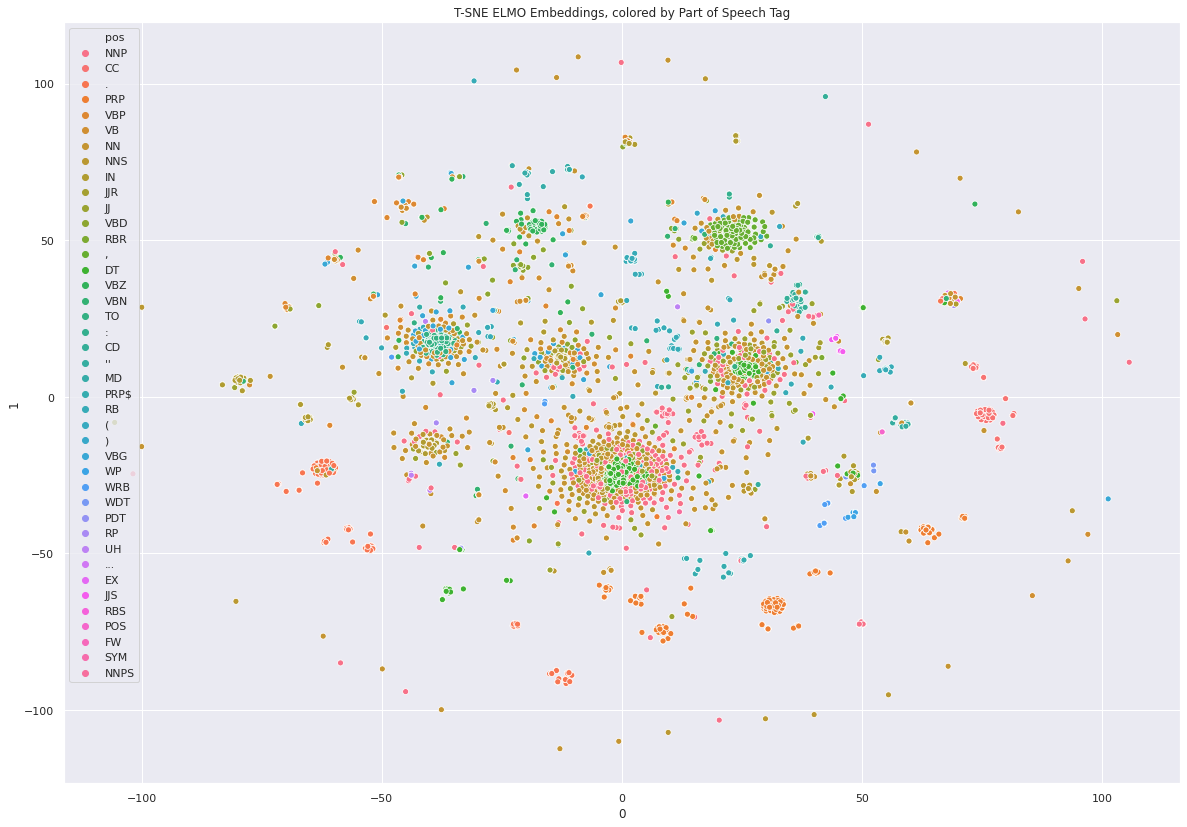

In [11]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.pos)
ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE ELMO Embeddings, colored by Part of Speech Tag')


##5.2 Plot low dimensional T-SNE ELMO embeddings with hue for Sarcasm


Text(0.5, 1.0, 'T-SNE ELMO Embeddings, colored by Sarcasm label')

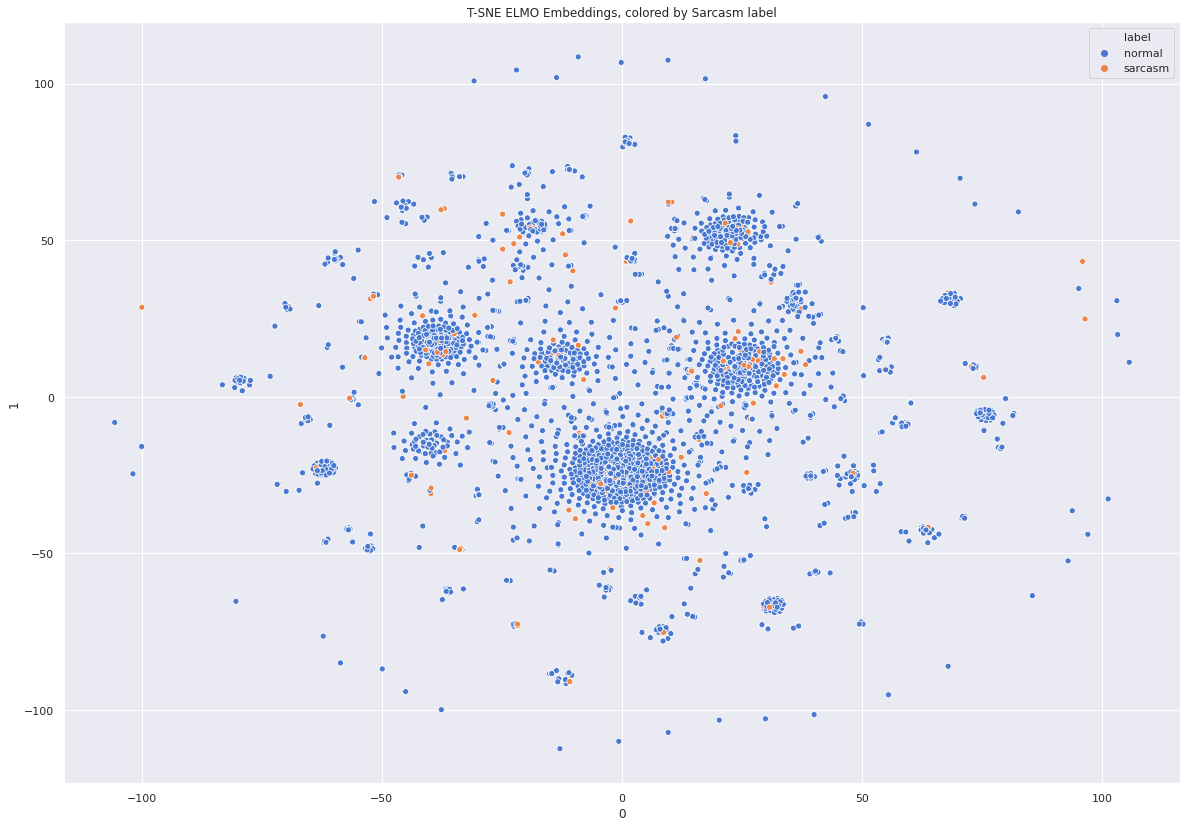

In [12]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.label.replace({1:'sarcasm',0:'normal'}))
ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE ELMO Embeddings, colored by Sarcasm label')


## 5.3 Plot low dimensional T-SNE ELMO embeddings with hue for Sentiment


Text(0.5, 1.0, 'T-SNE ELMO Embeddings, colored by Sentiment')

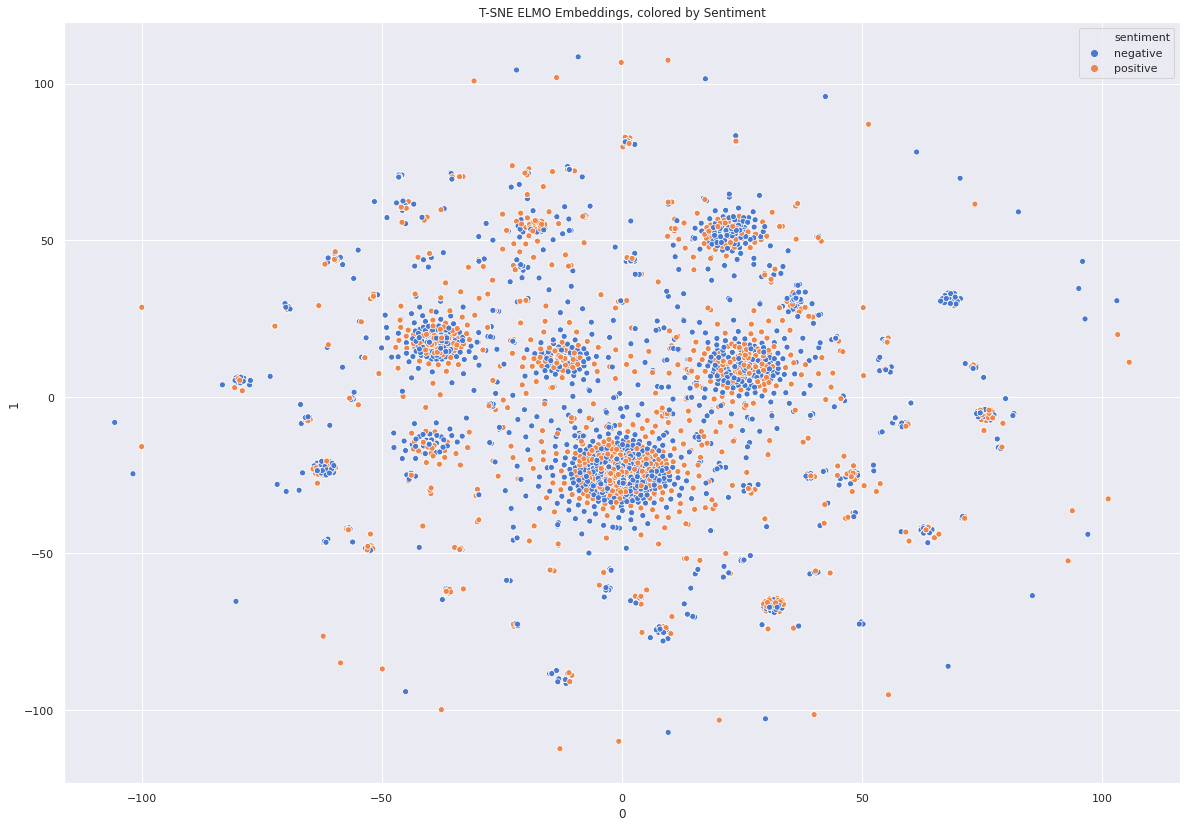

In [13]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.sentiment)
ax =  sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE ELMO Embeddings, colored by Sentiment')


# 5.4 Plot low dimensional T-SNE ELMO embeddings with hue for Emotions


Text(0.5, 1.0, 'T-SNE ELMO Embeddings, colored by Emotion')

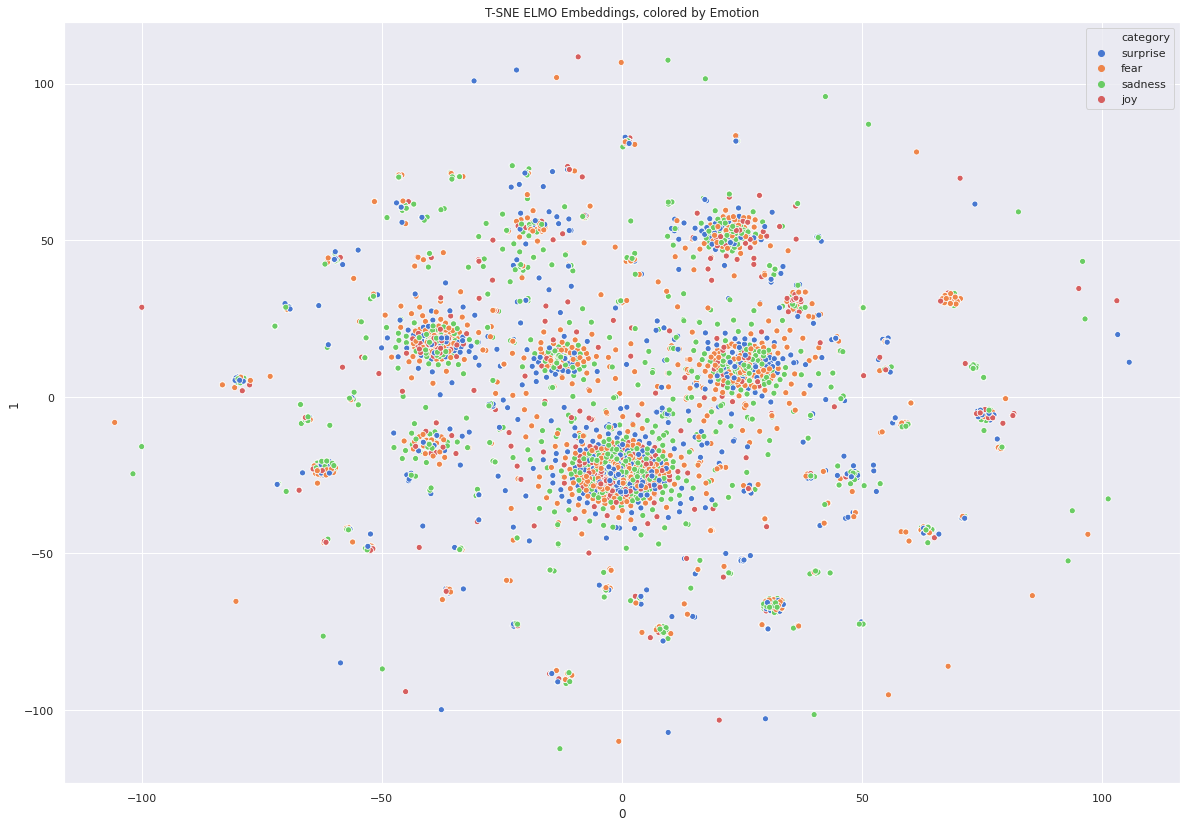

In [14]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.category)
ax =  sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE ELMO Embeddings, colored by Emotion')


## 6 Configure ELMO model parameters

ELMO 4 different output layers you can use, each encode words differently, try experimenting with them and see how the T-SNE plot change!     

Refer to the paper for further info

- word_emb: the character-based word representations with shape [batch_size, max_length, 512]. == word_emb

-  lstm_outputs1: the first LSTM hidden state with shape [batch_size, max_length, 1024]. === lstm_outputs1

-  lstm_outputs2: the second LSTM hidden state with shape [batch_size, max_length, 1024]. === lstm_outputs2

-  elmo: the weighted sum of the 3 layers, where the weights are trainable. This tensor has shape [batch_size, max_length, 1024] == elmo

In [15]:
pipe.print_info()

The following parameters are configurable for this NLU pipeline (You can copy paste the examples) :
>>> pipe['pos'] has settable params:
>>> pipe['sentence_detector'] has settable params:
pipe['sentence_detector'].setCustomBounds([])  | Info: characters used to explicitly mark sentence bounds | Currently set to : []
pipe['sentence_detector'].setDetectLists(True)  | Info: whether detect lists during sentence detection | Currently set to : True
pipe['sentence_detector'].setExplodeSentences(False)  | Info: whether to explode each sentence into a different row, for better parallelization. Defaults to false. | Currently set to : False
pipe['sentence_detector'].setMaxLength(99999)  | Info: Set the maximum allowed length for each sentence | Currently set to : 99999
pipe['sentence_detector'].setMinLength(0)  | Info: Set the minimum allowed length for each sentence. | Currently set to : 0
pipe['sentence_detector'].setUseAbbreviations(True)  | Info: whether to apply abbreviations at sentence det

## 6.1 Lets configure ELMO to use the 'elmo' layer instead of the 'word_emb' layer

In [16]:

pipe['elmo'].setPoolingLayer('elmo')

predictions = pipe.predict(df[['text','label']].iloc[0:500], output_level='token')
predictions

,category,category_confidence,label,checked,sentence_embeddings,pos,text,sentiment_confidence,sentiment,elmo_embeddings,token
origin_index,,,,,,,,,,,
0,surprise,0.972704,0,NC,"[[-0.06570463627576828, -0.03522053360939026, ...",NNP,NC and NH.,0.522900,negative,"[0.3901335895061493, -0.324570894241333, -0.19...",NC
0,surprise,0.972704,0,and,"[[-0.06570463627576828, -0.03522053360939026, ...",CC,NC and NH.,0.522900,negative,"[0.39937347173690796, -0.24899080395698547, 0....",and
0,surprise,0.972704,0,NH,"[[-0.06570463627576828, -0.03522053360939026, ...",NNP,NC and NH.,0.522900,negative,"[0.27646633982658386, 0.10830175876617432, 0.4...",NH
0,surprise,0.972704,0,.,"[[-0.06570463627576828, -0.03522053360939026, ...",.,NC and NH.,0.522900,negative,"[-0.35673195123672485, -0.2562720775604248, -0...",.
1,fear,0.999838,0,You,"[[-0.0254225991666317, 0.05448468029499054, -0...",PRP,You do know west teams play against west teams...,0.473300,negative,"[-1.2514702081680298, 0.06236444413661957, -0....",You
...,...,...,...,...,...,...,...,...,...,...,...
499,surprise,0.991925,0,for,"[[0.02939368598163128, -0.027575558051466942, ...",IN,Hard drive requirements tend to include extra ...,0.539600,positive,"[-0.32174891233444214, 0.9406865835189819, -0....",for
499,surprise,0.991925,0,the,"[[0.02939368598163128, -0.027575558051466942, ...",DT,Hard drive requirements tend to include extra ...,0.539600,positive,"[-0.031051956117153168, 0.4984866976737976, -0...",the
499,surprise,0.991925,0,file,"[[0.02939368598163128, -0.027575558051466942, ...",NN,Hard drive requirements tend to include extra ...,0.539600,positive,"[0.28061479330062866, 0.08399137854576111, -0....",file


## 6.2 Visualize embeddings of new ELMO output layer        
First we need to prepare the data agan

In [17]:
import numpy as np

# We first create a column of type np array
predictions['np_array'] = predictions.elmo_embeddings.apply(lambda x: np.array(x))
# Make a matrix from the vectors in the np_array column via list comprehension
mat = np.matrix([x for x in predictions.np_array])
mat.shape
from sklearn.manifold import TSNE
model = TSNE(n_components=2) #n_components means the lower dimension
low_dim_data = model.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

Lower dim data has shape (5876, 2)


## 6.3 T-SNE Elmo plot for new output layer with hue POS

Text(0.5, 1.0, 'T-SNE ELMO Embeddings, colored by Part of Speech')

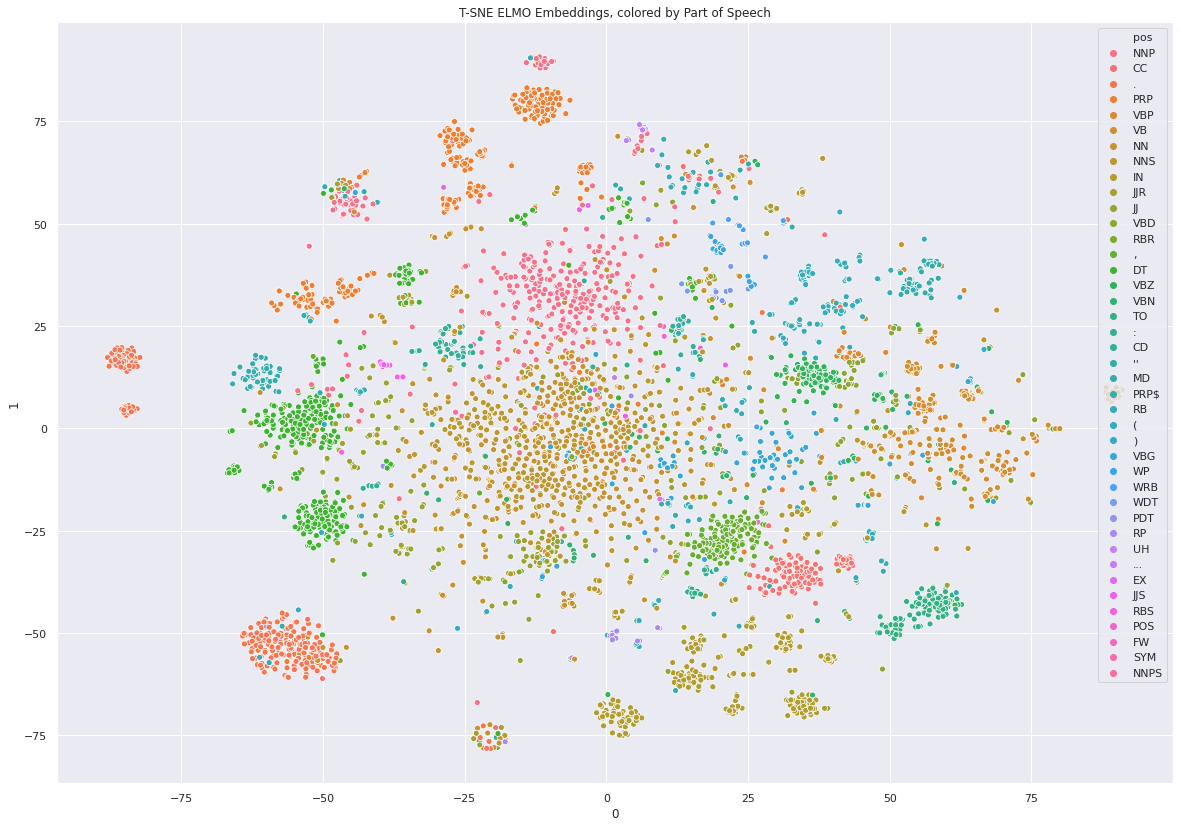

In [18]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.pos)
ax =  sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE ELMO Embeddings, colored by Part of Speech')


## 6.4 T-SNE Elmo plot for new output layer with hue Sentiment



Text(0.5, 1.0, 'T-SNE ELMO Embeddings, colored by Sentiment')

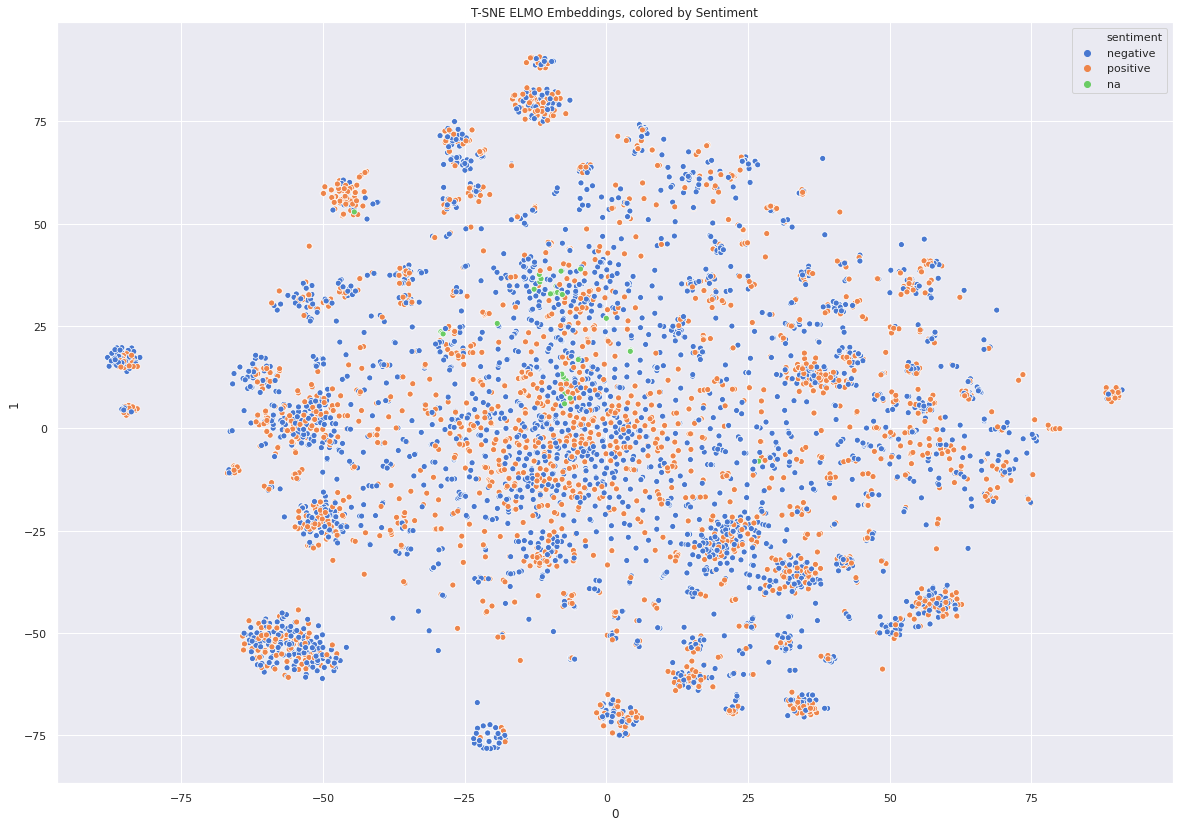

In [19]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.sentiment)
ax =  sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE ELMO Embeddings, colored by Sentiment')


## 6.5 T-SNE Elmo plot for new output layer with hue Emotion

Text(0.5, 1.0, 'T-SNE ELMO Embeddings, colored by Emotion')

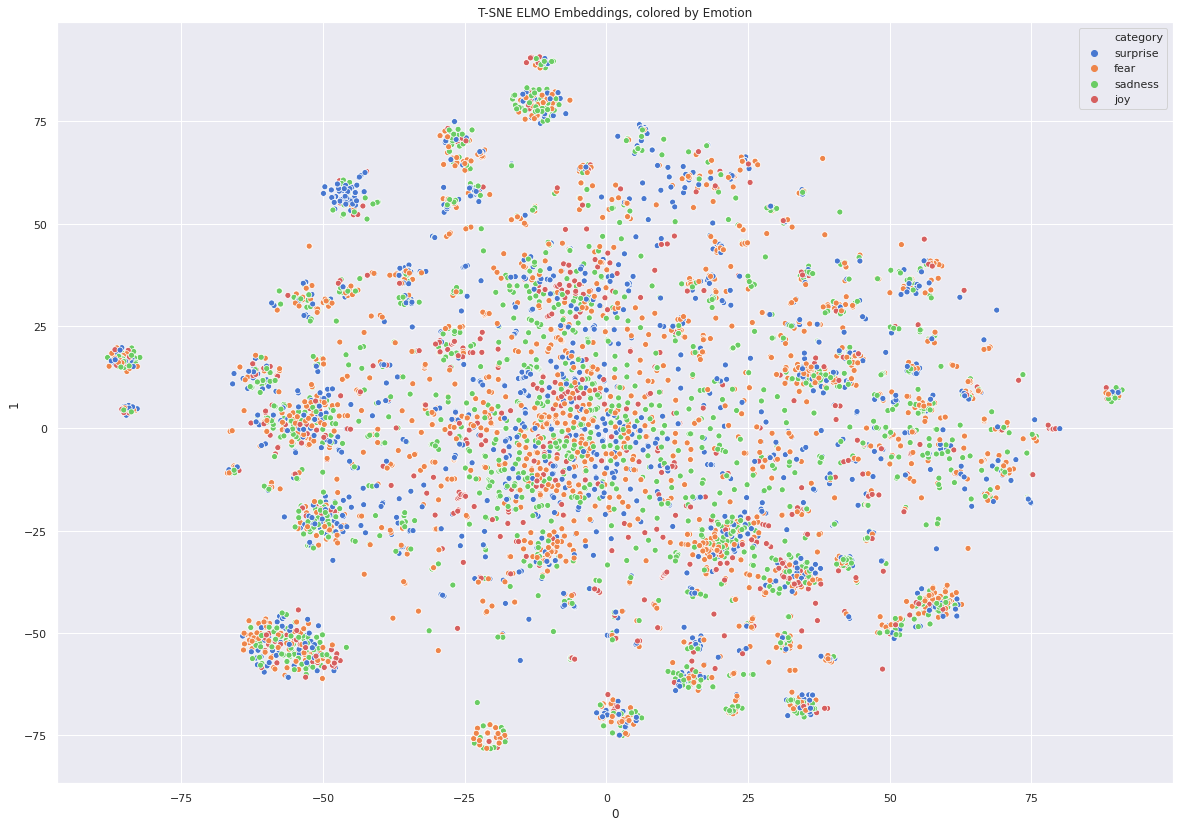

In [20]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.category)
ax =  sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE ELMO Embeddings, colored by Emotion')


# 7. NLU has many more embedding models!      
Make sure to try them all out!       
You can change 'elmo' in nlu.load('elmo') to bert, xlnet, albert or any other of the **100+ word embeddings** offerd by NLU

In [21]:
nlu.print_all_model_kinds_for_action('embed')

For language <en> NLU provides the following Models : 
nlu.load('en.embed') returns Spark NLP model glove_100d
nlu.load('en.embed.glove') returns Spark NLP model glove_100d
nlu.load('en.embed.glove.100d') returns Spark NLP model glove_100d
nlu.load('en.embed.bert') returns Spark NLP model bert_base_uncased
nlu.load('en.embed.bert.base_uncased') returns Spark NLP model bert_base_uncased
nlu.load('en.embed.bert.base_cased') returns Spark NLP model bert_base_cased
nlu.load('en.embed.bert.large_uncased') returns Spark NLP model bert_large_uncased
nlu.load('en.embed.bert.large_cased') returns Spark NLP model bert_large_cased
nlu.load('en.embed.biobert') returns Spark NLP model biobert_pubmed_base_cased
nlu.load('en.embed.biobert.pubmed_base_cased') returns Spark NLP model biobert_pubmed_base_cased
nlu.load('en.embed.biobert.pubmed_large_cased') returns Spark NLP model biobert_pubmed_large_cased
nlu.load('en.embed.biobert.pmc_base_cased') returns Spark NLP model biobert_pmc_base_cased
nlu.lo